In [1]:
import argparse
import collections
import functools
import json
import imageio
import os
import pathlib
import sys
import time
from PIL import Image
import skvideo.io
import matplotlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MUJOCO_GL'] = 'egl'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as prec
from blox.utils import AverageMeter, timing
from blox.basic_types import map_dict
import time
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

from tensorflow_probability import distributions as tfd

from utils import models, tools, wrappers, logging
from dreamer import Dreamer, preprocess, make_bare_env
import dreamer
from planners import gn_solver, gn_solver_goal
from dreamer_colloc import DreamerColloc, make_env
import dreamer_colloc

def define_config():
  config = dreamer_colloc.define_config()
  return config

Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']
Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']


No module named 'flow'
No module named 'carla'


In [2]:
# Parse arguments
try:
  import colored_traceback
  colored_traceback.add_hook()
except ImportError:
  pass
parser = argparse.ArgumentParser()
for key, value in define_config().items():
  parser.add_argument(f'--{key}', type=tools.args_type(value), default=value)
# args = \
# '--logdir ./logdir/mw_pickplace/dreamer_vis_online_gd200_fixed \
# --task mw_sawyer_SawyerPickPlaceEnvV2 \
# --action_repeat 1 \
# --time_limit 120 \
# --planning_task colloc_second_order \
# --planning_horizon 40 \
# --mpc_steps 40 \
# --gd_steps 200 \
# --logdir_colloc ./logdir_colloc/mw_pickplace/dreamer_vis_online_gd200_fixed \
# --rew_res_wt 1 \
# --dyn_threshold 1e-5 \
# --act_threshold 1e-5 \
# --coeff_normalization 1 \
# --eval_tasks 1 \
# --collect_sparse_reward True \
# --state_regressor True \
# --use_sparse_reward True'

args = \
'--logdir ./logdir/desk/random_sr/offline \
--task desk_door \
--action_repeat 1 \
--time_limit 10 \
--planning_task colloc_second_order \
--planning_horizon 10 \
--mpc_steps 10 \
--gd_steps 200 \
--logdir_colloc ./logdir/desk/vis \
--rew_res_wt 10 \
--dyn_threshold 1e-2 \
--act_threshold 1e-4 \
--coeff_normalization 1 \
--nu_lr 1 \
--state_regressor True \
--state_size 79 \
--eval_tasks 1'
config = parser.parse_args(args.split(' '))

if config.gpu_growth:
  for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
assert config.precision in (16, 32), config.precision
if config.precision == 16:
  prec.set_policy(prec.Policy('mixed_float16'))
config.steps = int(config.steps)
config.logdir.mkdir(parents=True, exist_ok=True)
print('Logdir', config.logdir)
config.logdir_colloc.mkdir(parents=True, exist_ok=True)

Logdir logdir/desk/random_sr/offline


In [3]:
# Create environment.
config.img_sz = 64
env = make_env(config)

# Create visualization environment
# suite, task = config.task.split('_', 1)
config.img_sz = 256
vis_env = make_env(config)._env._env

# Create and load agent.
actspace = env.action_space
datadir = config.logdir / 'episodes'
agent = DreamerColloc(config, datadir, actspace)
agent.load(config.logdir / 'variables.pkl')

setting param viewer_image_height to value 64
setting param viewer_image_width to value 64
setting param textured to value True


/nfs/kun1/users/oleg/anaconda3_nfs/envs/tf2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


setting param viewer_image_height to value 256
setting param viewer_image_width to value 256
setting param textured to value True
Found 5580699 model parameters.
Found 576006 actor parameters.
Found 413601 value parameters.


In [114]:
# Define task-related variables
assert config.planning_task == 'colloc_second_order'
actspace = env.action_space
obs = env.reset()
obs['image'] = [obs['image']]

# Obtain goal observation for goal-based collocation
is_goal_based = 'goal' in config.planning_task or config.goal_based
if is_goal_based:
  goal_obs = env.render_goal()
  imageio.imwrite('goal_img.jpg', goal_obs['image'])
  goal_obs['image'] = [goal_obs['image']]
else:
  goal_obs = None

# Planning steps
num_iter = config.time_limit // config.action_repeat
img_preds, act_preds, frames, plans = [], [], [], []
total_reward = 0
if config.collect_sparse_reward:
  total_sparse_reward = 0

for i in range(0, num_iter, config.mpc_steps):
  print("Planning step {0} of {1}".format(i + 1, num_iter))
  act_pred, img_pred, feat_pred, info = agent.collocation_so(obs, goal_obs, True, 0)
  # Simulate in env
  act_pred_np = act_pred.numpy()
  for j in range(len(act_pred_np)):
    obs, reward, done, env_info = env.step(act_pred_np[j])
    total_reward += reward
    if config.collect_sparse_reward:
        total_sparse_reward += env_info['success'] # float(info['goalDist'] < 0.15)
    frames.append(obs['image'])
  # Update observation
  obs['image'] = [obs['image']]
  # Logging
  act_preds.append(act_pred_np)
  img_preds.append(img_pred.numpy())
  plans.append(info['plans'])
  agent.logger.log_video(f"plan/{i}", img_pred.numpy())
  agent.logger.log_video(f"execution/{i}", frames[-len(act_pred_np):])

print(f"Total reward: {total_reward}")
# Log full videos
img_preds = np.vstack(img_preds)
agent.logger.log_video("plan/full", img_preds)
agent.logger.log_video("execution/full", frames)

Planning step 1 of 10
Final average dynamics loss: 0.00896578561514616
Final average action violation: 0.00013943910016678274
Final total reward: -3.351921796798706
Final average initial state violation: 1.3970596901557997e-09
Total reward: -0.9499276440019541


## Save Data

In [134]:
def save_plans(plans):
  # Save plans
  plans_np = []
  for i in range(len(plans)):
    single_plan = []
    for j in range(len(plans[0])):
      single_plan.append(plans[i][j].numpy())
    plans_np.append(single_plan)
  plans_np = np.array(plans_np)
  print(plans_np.shape)
  np.save(config.logdir_colloc / 'plans.npy', plans_np)

save_plans(plans)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [4]:
def render_state(env, state):
    assert (len(state.shape) == 1)
    # Save init configs
#     hand_init_pos = env._env.hand_init_pos
#     obj_init_pos = env._env.init_config['obj_init_pos']
#     # Render state
#     hand_pos, obj_pos, hand_to_goal = np.split(state, 3)
#     env._env.hand_init_pos = hand_pos
#     env._env.init_config['obj_init_pos'] = obj_pos
#     env._env.reset_model()
#     obs = env._get_obs(state)
    # Revert environment
#     env._env.hand_init_pos = hand_init_pos
#     env._env.init_config['obj_init_pos'] = obj_init_pos
    state = env._env.reset(state)
    obs = env._get_obs(state)
    return obs['image']
  
def render_states(env, states):
    assert (len(states.shape) == 2)
    imgs = []
    for s in states:
      img = render_state(env, s)
      imgs.append(img)
    return np.array(imgs)

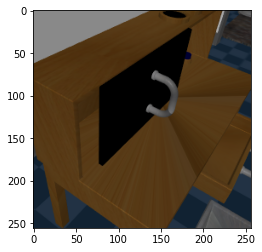

In [40]:
state = np.zeros([79])
# state = np.array([0.1263125, 0.73174214, 0.05957499, 0.12420364, 0.7611793, 0.03011783, -0.0260275, 0.07807945, -0.03987794])
state[:3] += np.array([0., 0.0, -0.0])
frame = render_states(vis_env, state[None])
np.save(config.logdir_colloc / 'background.npy', frame[0])
plt.imshow(frame[0])
plt.show()

## Composite Plans

In [6]:
def visualize_plan_background(plans, background, config, mode=None, num_shadows=4):
  import cv2
  video = []
  fg_masks = []
  opt_steps = config.gd_steps
  opt_int = 2
  traj_int = config.planning_horizon // num_shadows
  for plan in plans[:opt_steps:opt_int]:
    plan = plan[0, :-1:traj_int, :-3] # Take 5 latent states without actions
    states = agent._state(plan).mode().numpy()
    # Avoid contact 
    # states[:, :3] += np.array([0., 0.0, 0.03])
    if mode == 'obj':
      states[:, :3] = np.array([0., 0., 0.2])
    elif mode == 'hand':
      states[:, 3:6] = np.array([0., 0., 0.02])
    frames = render_states(vis_env, states)
    dst = bg.copy()
    fg_mask_combined = np.zeros_like(frames[0])
    for i in range(frames.shape[0] - 1, -1, -1):
      frame = frames[i]
      fg_mask = frame != background
      frame[1 - fg_mask] = 0.0
      dst[fg_mask] = frame[fg_mask]
      fg_mask_combined = np.logical_or(fg_mask_combined, fg_mask)
    video.append(dst)
    fg_masks.append(np.array(fg_mask_combined))
  return np.stack(video, 0), np.stack(fg_masks, 0)

In [48]:
import cv2
plans = np.load(config.logdir_colloc / "plans.npy")
bg = np.load(config.logdir_colloc / "background.npy")
for i in range(len(plans)):
  video, mask = visualize_plan_background(plans[i,], bg, config, num_shadows=4)
#   fname_hand = f'result_sparse_hand_bg' + str(i)
#   skvideo.io.vwrite(config.logdir_colloc / f'{fname_hand}.mp4', video_hand, inputdict={'-r': '10'})
#   video_obj, mask_obj = visualize_plan_background(plans[i], bg, config, 'obj', 8)
#   fname_obj = f'result_sparse_obj_bg' + str(i)
#   skvideo.io.vwrite(config.logdir_colloc / f'{fname_obj}.mp4', video_obj, inputdict={'-r': '10'})
#   video = np.zeros_like(video_hand)
#   for j in range(len(video_hand)):
#     frame_obj = bg.copy()
#     frame_hand = bg.copy()
#     frame_obj[mask_obj[j]] = video_obj[j][mask_obj[j]]
#     frame_hand[mask_hand[j]] = video_hand[j][mask_hand[j]]
#     frame = cv2.addWeighted(frame_obj, 0.5, frame_hand, 0.5, 0.0)
#     video[j] = frame
  fname = f'result_sparse_combined_6fps_short' + str(i)
  skvideo.io.vwrite(config.logdir_colloc / f'{fname}.gif', video[:len(video) // 2], inputdict={'-r': '6'})
  break

In [45]:
fname = f'result_sparse_combined_6fps_short' + str(i)
skvideo.io.vwrite(config.logdir_colloc / f'{fname}.gif', video[:len(video) // 2], inputdict={'-r': '3'})
skvideo.io.vwrite(config.logdir_colloc / f'{fname}.mp4', video[:len(video) // 2], inputdict={'-r': '3'})

In [46]:
plans_plot = plans[0, -1:]
background = bg
num_shadows = 4
eps = 50

video = []
fg_masks = []
opt_steps = config.gd_steps
opt_int = 1
traj_int = config.planning_horizon // num_shadows
for plan in plans_plot[::opt_int]:
    plan = plan[0, :-1:traj_int, :-3] # Take 5 latent states without actions
    states = agent._state(plan).mode().numpy()
    frames = render_states(vis_env, states)
    dst = bg.copy()
    fg_mask_combined = np.zeros_like(frames[0])
    for i in range(frames.shape[0] - 1, -1, -1):
        frame = frames[i]
        fg_mask = (np.abs(frames[i] - background).astype(float).mean(-1) > eps)[..., None][..., [0,0,0]]
#         fg_mask = frames[i] != background
        print(i, fg_mask.sum())
#         frame[1 - fg_mask] = 0.0
        dst[fg_mask] = frame[fg_mask]
        fg_mask_combined = np.logical_or(fg_mask_combined, fg_mask)
video.append(dst)
fg_masks.append(np.array(fg_mask_combined))

video, masks = np.stack(video, 0), np.stack(fg_masks, 0)

4 39570
3 39261
2 31794
1 20043
0 28116


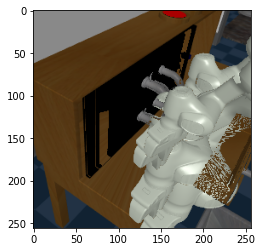

In [47]:
# video.shape
plt.imshow(video[0])
# plt.imshow(frames[1])
# plt.imshow(background)
# plt.imshow(bg - frames[0])
# frames.shape

# plt.imshow(fg_mask.astype(float))
# plt.imshow(np.abs(frames[i] - background).astype(float).mean(-1))

# bg = np.load(config.logdir_colloc / "background.npy")
# states = agent._state(plans[0,0,0,:,:-3]).mode().numpy()
# frames = render_states(vis_env, states)

In [34]:
# plt.imshow(frames[10])
# np.unique((frames[i] - background).mean(-1))
fg_mask.dt

# vis_env = make_env(config)._env._env

(256, 256, 3)

In [99]:
import cv2
plans = np.load(config.logdir_colloc / "plans.npy")
i = -1
plan = plans[0]
video = agent._decode(plan[..., :-3]).mode().numpy()[:, 0]

blend_video = (video + 0.5).mean(1)

fname = f'visualization' + str(i)
skvideo.io.vwrite(config.logdir_colloc / f'{fname}.gif', blend_video[:len(blend_video) // 2], inputdict={'-r': '6'})


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


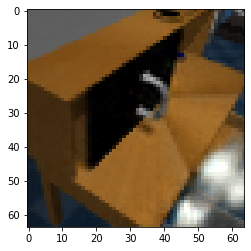

In [107]:
img = video[-1] + 0.5
# blend = img[::].mean(0)
# blend = img[5]
plt.imshow(blend)

In [122]:
plans.shape

(1, 200, 1, 11, 233)